1. **Import Necessary Libraries**:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

2. **Load and Preprocess the Data**:

- **Read the CSV File**:

In [ ]:
# Replace 'data.csv' with the path to your CSV file
df = pd.read_csv('data.csv')


   - **Drop Unnecessary Columns**:


In [3]:
# Drop the 'kids' column
# df = df.drop('kids', axis=1)

   - **Handle Missing Values**:

In [4]:
# Check for missing values
if df.isnull().values.any():
    df = df.dropna()

- **Process the Data**

In [5]:
# Adjust the path based on your directory structure
df['image'] = df['image'].apply(lambda x: f'images/{x}')

# Encode labels for Top, Bottom, and Dress
df['label'] = df[['Top', 'Bottom', 'Dress']].apply(lambda x: ''.join(x.astype(str)), axis=1)

# Filter DataFrame to only include rows with valid labels
df = df[df['label'].str.contains('1')]
df

,image,Uniqlo,H&M,Net,50 percent,GAP,AIR SPACE,short,long,Top,...,jeans/demi skirt,cargo pants/skirt,sweat pants/sports skirt,overalls/jumper skirt,leggings,casual pants/skirt,pleated skirt,dress pants/skirt,price,label
0,images/T-shirt with a motif - Tannah Ghiellana...,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,499,100
1,images/patterned shirt - Tannah Ghiellana Soli...,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,999,100
2,images/Muslin dress - Tannah Ghiellana Soliven...,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,699,001
3,images/wide trousers - Tannah Ghiellana Solive...,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,999,010
4,images/Canvas cargo trousers - Tannah Ghiellan...,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,699,010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,images/2430726009-210 - Tannah Ghiellana Soliv...,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1300,100
835,images/2430727006-003 - Tannah Ghiellana Soliv...,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,990,100
836,images/2430727006-006 - Tannah Ghiellana Soliv...,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,990,100
837,images/2430727008-019 - Tannah Ghiellana Soliv...,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1100,100


   - **Split Data into Training and Validation Sets**:

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


3. **Prepare Image Data Generators**:

In [7]:
# Define image size and batch size
img_height, img_width = 128, 128
batch_size = 32

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 671 validated image filenames belonging to 3 classes.
Found 168 validated image filenames belonging to 3 classes.


4. **Build the CNN Model**:

In [8]:
model = Sequential()

# Input layer (explicitly defined)
model.add(Input(shape=(img_height, img_width, 3)))

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
# Ensure n_classes matches the number of unique classes
n_classes = df['label'].nunique()
model.add(Dense(n_classes, activation='softmax'))


5. **Compile and Train the Model**:

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=1000,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size
)

C:\Users\EMMA2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5737 - loss: 1.1089 - val_accuracy: 0.6375 - val_loss: 0.9632
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7188 - loss: 0.7013 - val_accuracy: 0.2500 - val_loss: 0.9061
Epoch 3/1000


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.7201 - loss: 0.6593 - val_accuracy: 0.6687 - val_loss: 0.7100
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8125 - loss: 0.4768 - val_accuracy: 0.6250 - val_loss: 0.7265
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.7933 - loss: 0.5170 - val_accuracy: 0.7688 - val_loss: 0.5524
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8125 - loss: 0.3646 - val_accuracy: 0.8750 - val_loss: 0.5099
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - accuracy: 0.7871 - loss: 0.4875 - val_accuracy: 0.7750 - val_loss: 0.4791
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7812 - loss: 0.4313 - val_accuracy: 0.6250 - val_loss: 0.6143
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - accuracy: 0.8279 - loss: 0.4087 - val_accuracy: 0.7750 - val_loss: 0.5438
Epoch 10/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9375 - loss: 0.3193 - val_accuracy: 0.7500

6. **Evaluate the Model**:

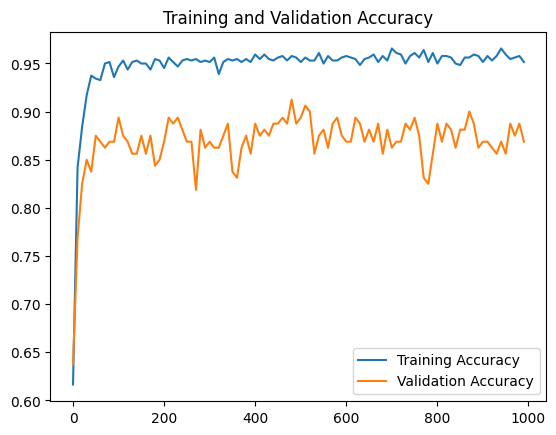

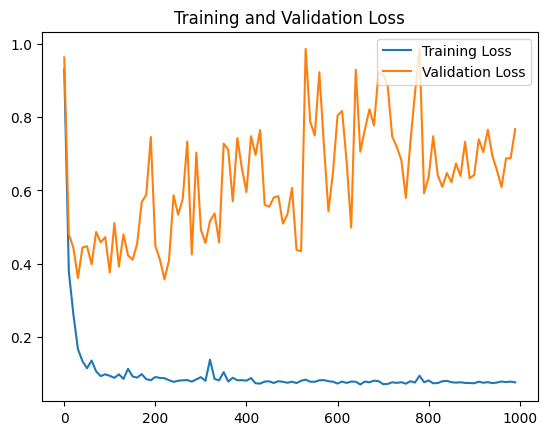

In [22]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# only plot every 10th epoch
epochs_range = epochs_range[::10]
acc = acc[::10]
val_acc = val_acc[::10]
loss = loss[::10]
val_loss = val_loss[::10]

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

7. **Save the Model**:


In [23]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')
model.save('part.keras')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8838 - loss: 0.7077
Loss: 0.6607685089111328, Accuracy: 0.886904776096344
